In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import  matplotlib.pyplot as plt

In [3]:
for i in range(10):
    numpy_array = np.load(f'./output_arrays/epoch_{i}_channel_{i}.npy')
    print("min: ",np.max(numpy_array)," min: ", np.min(numpy_array))

min:  -18.5896630128767  min:  -39.63681780326855
min:  -18.141701460897213  min:  -36.8904465762907
min:  -18.290000466448497  min:  -37.17173698496737
min:  -16.519613035035665  min:  -35.93910966205393
min:  -20.863681885700743  min:  -36.62078477154287
min:  -18.031706155218004  min:  -38.59213441837108
min:  -17.532642729382108  min:  -37.500836179614105
min:  -17.717535093620913  min:  -37.03270832789259
min:  -17.73471230117914  min:  -36.56147077649449
min:  -20.073237518418782  min:  -38.595491167248326


In [2]:
numpy_array=np.load('./output_arrays/epoch_0_channel_0.npy')
n_freqs,n_times=numpy_array.shape
n_freqs,n_times

(140, 2560)

# Data loader

In [3]:
class NpyImageDataset(Dataset): #Interfaz Dataset de Pytorch 
    def __init__(self, image_shape, root_dir='./output_arrays/', transform=None):
        """
        root_dir (string): Folder con archivos .npy.
        transform (callable, optional)
        """
        self.root_dir = root_dir
        self.n_freqs,self.n_times=image_shape
        self.transform = transform
        self.image_files_names = [f for f in os.listdir(root_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.image_files_names)

    def __getitem__(self, idx):
        # Load .npy file
        file_name=self.image_files_names[idx]
        img_path = os.path.join(self.root_dir, file_name)
        image = np.load(img_path)
        
        image = image.reshape(1, self.n_freqs, self.n_times)
        epoch = int(file_name.split('epoch_')[1].split('_')[0])
        channel = int(file_name.split('channel_')[1].split('.')[0])

        # Convert image to a PyTorch tensor
        image = torch.from_numpy(image).float()
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, epoch, channel# Retorna (input, numero_epoch,numero_channel). En entrenamiento uso sólo image
        
class MinMaxNormalize:
    def __call__(self, image):
        min_val = image.min()
        max_val = image.max()
        return (image - min_val) / (max_val - min_val + 1e-8)


In [4]:
image_transforms = transforms.Compose([
    #transforms.resize((n_freqs, n_times))
    #transforms.Normalize((0.5,), (0.5,))
    MinMaxNormalize()
])

dataset = NpyImageDataset((n_freqs,n_times), root_dir='./output_arrays/', transform=image_transforms) #input_shape=(n_freqs,n_times),
dataloader = DataLoader(dataset,
                        batch_size=16,
                        num_workers=4)

# VAE

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_shape, interm_dim=150, latent_dim=16,variational=False):
        super(Encoder, self).__init__()
        self.variational=variational
        n_freqs, n_times = input_shape

        # Capas convolucionales
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,5),stride=2)
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=(1, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3,stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1, 2))##Comentar
        self.bn2= nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16,kernel_size=3,stride=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(16)
        # Determinación de shape luego de convolución
        self.conv_c_out,self.conv_h_out,self.conv_w_out=self._get_conv_output(input_shape)
        self.conv_output_size = self.conv_c_out*self.conv_h_out*self.conv_w_out
        
        # Capas fully connected para espacio latente
        self.fc_1=nn.Linear(self.conv_output_size,interm_dim)
        self.fc_mu = nn.Linear(interm_dim, latent_dim) #De representación intermedia a latente
        if self.variational:
            self.fc_logvar = nn.Linear(interm_dim, latent_dim)
        print("Instanciado encoder")

    def _get_conv_output(self, input_shape):
        """Función auxiliar en cálculo de tamaño tras convoluciones
        Retorna (C_out,H_out,W_out): numero de canales, altura y ancho de salida."""
        with torch.no_grad():
            x = torch.zeros(1, 1, *input_shape)  # Create a dummy input with batch size 1
            x = self.conv1(x)
            #x = self.maxpool1(x)
            x = self.conv2(x)
            #x = self.maxpool2(x)
            x = self.conv3(x)
            x = self.maxpool1(x)
            #x = self.maxpool3(x)
        
            return x.shape[1],x.shape[2],x.shape[3]
            
    def forward(self, x):
        
    # print(f"Input dimensions: {x.shape}")
        x = F.relu(self.conv1(x))
    # print(f"Encoder conv1: {x.shape}")
        
        x = F.relu(self.conv2(x))
        #x = self.maxpool2(x)
        x = self.bn2(x)
    # print(f"Encoder capa 2: {x.shape}")
        x = F.relu(self.conv3(x))
        #x = self.maxpool3(x)
        x = self.bn3(x)
    # print(f"Encoder capa 3: {x.shape}")
        x = self.maxpool1(x)
    # print(f"Encoder maxpool: {x.shape}")
        # Flatten the output
        x = torch.flatten(x, start_dim=1)
    # print("Encoder Forward: Flatten alcanzado. x.hape: ",x.shape, "Predicted output size: ", self.conv_output_size)
        x =F.relu(self.fc_1(x))
    # print("Linear 1: ",x.shape)
        # Obtener parámetros mu, logvarianza
        
        mu = self.fc_mu(x)
    # print("Mu alcanzado",mu.shape)
        if self.variational:
            logvar = self.fc_logvar(x)
            return mu,logvar
        return mu

class Decoder(nn.Module):
    def __init__(self, input_shape, encoder_conv_output_shape,interm_dim=150,latent_dim=16):
        super(Decoder, self).__init__()
        self.n_freqs, self.n_times = input_shape
        # Shape luego de convoluciones en el encoder para hacer reshaping
        self.conv_output_shape = encoder_conv_output_shape
    # print(self.conv_output_shape)
        encoder_conv_output_size=self.conv_output_shape[0]*self.conv_output_shape[1]*self.conv_output_shape[2]
        # Fully connected layer for reconstructing feature map shape
        self.fc=nn.Linear(latent_dim,interm_dim)
        self.fc_1 = nn.Linear(interm_dim, encoder_conv_output_size)#C*H*W
        #En el forward, se hace el view y se obtiene dimensión (C,H,W) de representación intermedia
        
        # Deconvolution layers
        self.bn1 = nn.BatchNorm2d(16)
        self.deconv1 = nn.ConvTranspose2d(16, 8, kernel_size=3,stride=2,output_padding=1)
        self.upsample1 = nn.Upsample(scale_factor=(1, 2))
        self.deconv2 = nn.ConvTranspose2d(8, 8, kernel_size=3,stride=2,output_padding=(0,1))
        self.bn2 = nn.BatchNorm2d(8)
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.deconv3 = nn.ConvTranspose2d(8, 1, kernel_size=(3,5),stride=2,output_padding=1)
        print("Instanciado decoder")

    def forward(self, x):#x: entrada de espacio latente
        # Decode fully connected to a feature map
        x = F.relu(self.fc(x))
    # print(f"Decoder capa lineal 1: {x.shape}")
        x = F.relu(self.fc_1(x))
    # print(f"Decoder capa lineal 2: {x.shape}")
        
        # El 1 se refiere a a la dimensión 
        x = x.unflatten(1, self.conv_output_shape) # "desarma" la dimensión 1 en (C,H,W)
    # print(f"Decoder unflattened: {x.shape}")
        
        x = self.upsample1(x)
    # print(f"Decoder upsample: {x.shape}")
        # Apply deconvolutions
        x = F.relu(self.deconv1(x))
        x = self.bn1(x)
    # print(f"Decoder capa 1: {x.shape}")
        
        x = F.relu(self.deconv2(x))
        x = self.bn2(x)
    # print(f"Decoder capa 2: {x.shape}")
        #x = self.upsample1(x)
        #print(f"Decoder upsample: {x.shape}")
        x = torch.sigmoid(self.deconv3(x))
        #x = self.upsample2(x)
    # print(f"Decoder capa 3: {x.shape}")

        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape, interm_dim=150, latent_dim=16,variational=False):
        super(VariationalAutoencoder, self).__init__()
        
        self.variational=variational
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.encoder = Encoder(input_shape, interm_dim=interm_dim,latent_dim=latent_dim,variational=variational).to(self.device)
        encoder_conv_c_h_w_out=(self.encoder.conv_c_out,self.encoder.conv_h_out,self.encoder.conv_w_out)
        self.decoder = Decoder(input_shape,encoder_conv_c_h_w_out, interm_dim=interm_dim,latent_dim=latent_dim).to(self.device)
     
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std
    
    def forward(self, x):
        if self.variational:# Encode
            x = x.to(self.device)
            mu, logvar = self.encoder(x)
            # Reparameterize
            z = self.reparameterize(mu, logvar)
            # Decode
            
            reconstructed = self.decoder(z)
            return reconstructed, mu, logvar
        else: 
            z=self.encoder(x)
            reconstructer=self.decoder(z)
            return reconstructed
# Define loss function
def loss_funct(reconstructed, original, mu=None, logvar=None, kld_weight=0.1,variational=False):
    """
    Compute VAE loss with weighted KL divergence
    """
    device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reconstructed.to(device)
    original.to(device)
    recon_loss = F.mse_loss(reconstructed,original,reduction='sum') #F.binary_cross_entropy(reconstructed, original, reduction='sum')
    if variational:
        
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_weight * kld_loss
    else:
        return recon_loss

In [6]:
# Prueba
input_shape=(140,2560)
encod=Encoder(input_shape,variational=True)
x_pr = torch.zeros(16, 1, *input_shape)
mu,logvar=encod.forward(x_pr)
conv_c_h_w_out=encod.conv_c_out,encod.conv_h_out,encod.conv_w_out
decod=Decoder(input_shape,conv_c_h_w_out)
auto=VariationalAutoencoder(input_shape,variational=True)
z=auto.reparameterize(mu,logvar)
decod.forward(z).shape

Instanciado encoder
Instanciado decoder
Instanciado encoder
Instanciado decoder


torch.Size([16, 1, 140, 2560])

In [7]:
# import CVA
input_shape = (n_freqs, n_times) 
latent_dim = 16
variational=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if variational:
    model = VariationalAutoencoder(input_shape=input_shape, latent_dim=latent_dim,variational=True).to(device)
else: 
    model = VariationalAutoencoder(input_shape=input_shape, latent_dim=latent_dim,variational=False).to(device) 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Instanciado encoder
Instanciado decoder


In [17]:
device

'cuda:0'

In [8]:
num_epochs = 10  
avg_epoch_loss_list=[]
for epoch in range(num_epochs):#training epochs
    model.train()  
    total_loss = 0
    
    for batch in dataloader:  # minibatch
        images,_,_=batch # epochs y channels: lista de epocs y canales correspondientes a cada imagen
        images.to(device) # (batch_size,1,n_freqs,n_times)
        # Forward     
        if model.variational:
            reconstructed, mu, logvar = model(images)
            reconstructed.to(device),mu.to(device),logvar.to(device)
            loss = loss_funct(reconstructed, images, mu, logvar, variational=True)
        else:
            reconstructed = model(images)
            loss = loss_funct(reconstructed, images, variational=False)
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the loss
        total_loss += loss.item()
    
    # Print average loss per epoch
    average_loss = total_loss / len(dataloader.dataset)
    avg_epoch_loss_list.append(average_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")


Epoch [1/10], Loss: 5543.7519
Epoch [2/10], Loss: 2964.9217
Epoch [3/10], Loss: 2916.1123
Epoch [4/10], Loss: 2875.4984
Epoch [5/10], Loss: 2854.1309
Epoch [6/10], Loss: 2793.4276
Epoch [7/10], Loss: 2724.7412
Epoch [8/10], Loss: 2489.2102
Epoch [9/10], Loss: 2370.4370
Epoch [10/10], Loss: 2328.3296


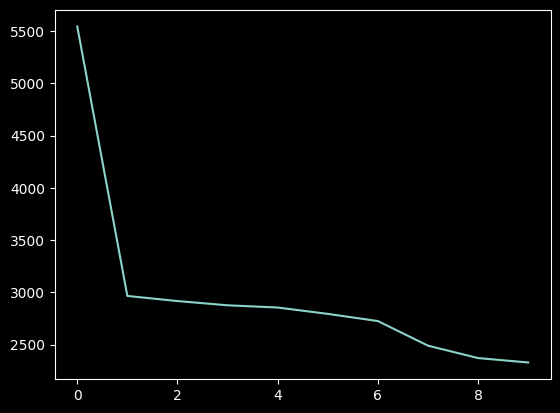

In [16]:
plt.plot(avg_epoch_loss_list)

# Latent representation 

In [50]:
latent_representations = []  # vectores de espacio latente
# latent_logvars=[]
metadata = []  # Información de epoch y channel

model.eval() 
with torch.no_grad():
    for images, epochs, channels in dataloader:
        
        images = images.to(device)  
        
        # Encode to latent space
        if model.variational:
            mu, logvar = model.encoder(images) ## Llama al forward del encoder
            #mu y logvar arrays de dim [barch_size,latent_dim]
            latent_vecs = model.reparameterize(mu,logvar)
        else:
            latent_vecs = model.encoder(images)
       
    
        latent_representations.append(latent_vecs.cpu())  # Llatent vectors a CPU
        #Cada entrada de latent: [batch_size,latent_dim]
        metadata.append((epochs, channels))
        # cada entrada de metadata: tupla, cada entrada vector (Tensor) de long [16]


In [51]:
latent_representations = np.array(torch.cat(latent_representations, dim=0))
#Pasa de lista de arrays a un vstack de los arrays (batch_size*len(lista) es igual a n_samples)(dimensiones [n_samples,latent_dim])
metadata = torch.cat([torch.stack(m) for m in metadata], dim=1) #primero desarma los batches (el último tiene 4 samples)
# Dimensiones [batch_size*len(lista),2]
#Cada fila en metadata (epoch,channel) corresponde con el vector en latent_representations
metadata=np.array(metadata).T # Cada fila corresponde a un sample


output_dir = './latent_space_VAE_outputs'
os.makedirs(output_dir, exist_ok=True)

np.savez(os.path.join(output_dir, 'latent_and_metadata.npz'), latent_vectors=latent_representations, metadata=metadata)

In [52]:
latent_representations.shape

(1620, 16)

# Lectura

In [ ]:
# Lectura
data = np.load('latent_and_metadata.npz')
latent_representations = data['latent_vectors']
metadata = data['metadata']

In [55]:
epochs = metadata[:,0]  # Epoch indices
channels = metadata[:,1]  # Channel indices

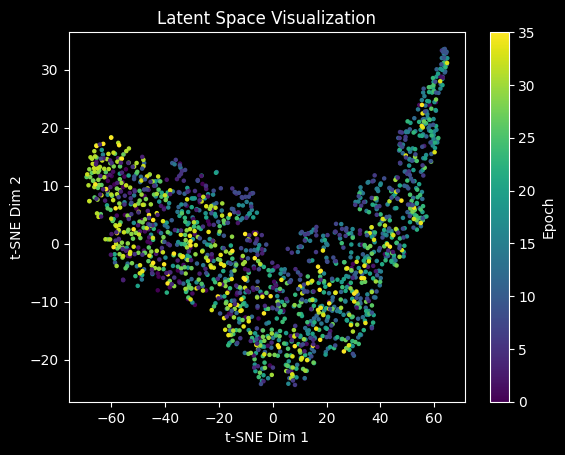

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_representations)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=epochs, cmap='viridis', s=5)
plt.colorbar(label='Epoch')
plt.title('Latent Space Visualization')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()


In [75]:
import umap #umap-learn package
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(latent_representations)

# Plot UMAP embeddings
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=epochs, cmap='viridis', alpha=0.7)  # Color by epoch
plt.colorbar(label="Epoch")
plt.title("UMAP Visualization of Latent Representations")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'